In [1]:
import pyspark
from pyspark import SparkContext
from pyspark.sql import SQLContext
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from textblob import TextBlob
%matplotlib inline

In [2]:
sc = SparkContext().getOrCreate()
sqlContext = SQLContext(sc)

In [3]:
df = sqlContext.read.json(
    'file:///mnt/c/Linux/Phase2/tweets_final_four.json')

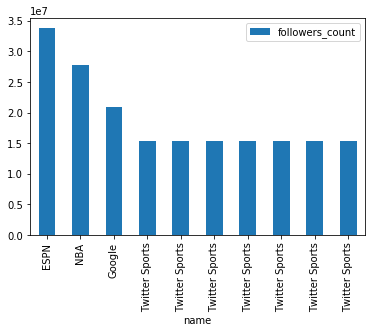

In [5]:
df.registerTempTable("tweets")
followers_count = sqlContext.sql("SELECT user.name, user.followers_count from tweets")
top_10_follow = followers_count.toPandas().sort_values(by=["followers_count"],ascending=False).head(10)
top_10_follow
top_10_follow.plot.bar(x = 'name')

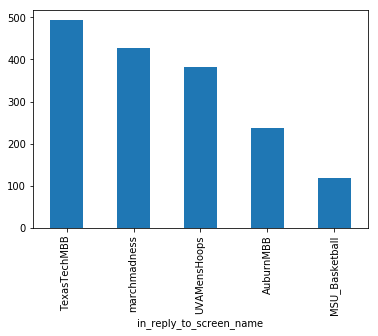

In [6]:
q = sqlContext.sql("SELECT in_reply_to_screen_name FROM tweets")
q.toPandas().groupby('in_reply_to_screen_name').size().nlargest(5).plot.bar()

In [18]:
#Follower counts by team
#Positivity by fanbase
#Correlation between followers and retweet count

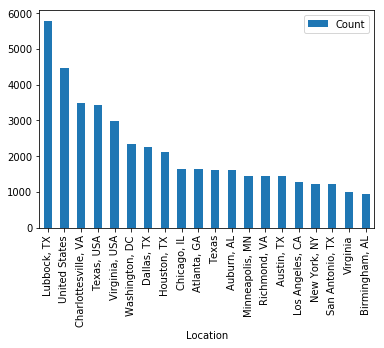

In [7]:
q = sqlContext.sql("SELECT user.location from tweets")
locations = []
for item in q.collect():
    if item[0] != None:
        locations.append(item[0])
count = Counter(locations)
top_ten = count.most_common(20)
pd_df = pd.DataFrame(top_ten, columns = ['Location', 'Count'])
pd_df.plot.bar(x = 'Location')

In [22]:
q = sqlContext.sql("SELECT entities.hashtags from tweets")
TTU = ['4to1', 'WreckEm', 'wreckem', 'TTU', 'ttu']
MSU = ['Spartans', 'spartans', 'GoGreen', 'gogreen', 'MSU', 'msu']
Auburn = ['WarEagle', 'wareagle', 'Auburn', 'auburn']
Virginia = ['UVA', 'uva', 'GoHoos', 'gohoos', 'Wahoowa', 'wahoowa']
team_count = {'TTU':0, 'MSU':0, 'Auburn':0, 'Virginia':0}
hashtags = []
for item in q.collect():
    if item[0] != None:
        for val in item[0]:
            if val[1] in TTU:
                team_count['TTU'] = team_count.get('TTU') + 1
            if val[1] in MSU:
                team_count['MSU'] = team_count.get('MSU') + 1
            if val[1] in Auburn:
                team_count['Auburn'] = team_count.get('Auburn') + 1
            if val[1] in Virginia:
                team_count['Virginia'] = team_count.get('Virginia') + 1
pd.DataFrame.from_dict(team_count, orient='index', columns=['count']).sort_values(by=['count'], ascending=False)

,count
Virginia,50267
TTU,26811
Auburn,17367
MSU,8344


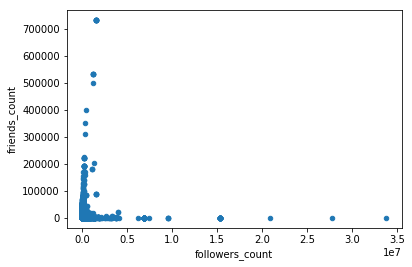

In [24]:
q = sqlContext.sql("SELECT user.followers_count, user.friends_count from tweets")
q.toPandas().plot.scatter(x = 'followers_count', y = 'friends_count')

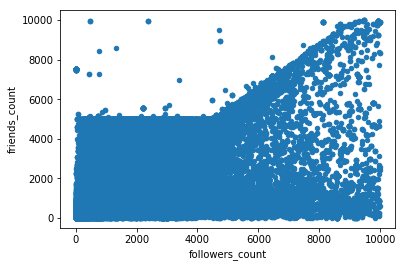

In [25]:
q = sqlContext.sql("SELECT user.followers_count, user.friends_count from tweets where user.friends_count < 10000 and user.followers_count < 10000")
q.toPandas().plot.scatter(x = 'followers_count', y = 'friends_count')

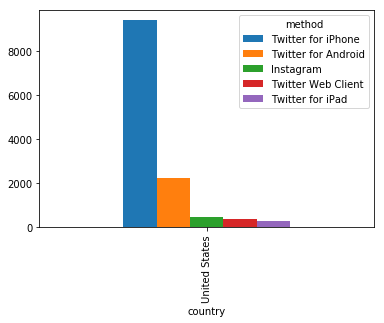

In [28]:
q = sqlContext.sql("SELECT source, place.country from tweets where place.country in ('United States')")
q.collect()
pd_df = q.toPandas()
pd_df[['source', 'method']] = pd_df['source'].str.split('">', expand=True)
pd_df['method'] = pd_df['method'].str.strip('</a>')
pd_df.groupby(['country','method']).size().nlargest(5).unstack(fill_value=0).plot.bar()

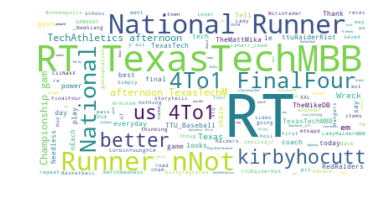

In [29]:
q = sqlContext.sql("SELECT text FROM tweets WHERE user.location = 'Lubbock, TX'")
text = q.toPandas()
wordcloud = WordCloud(background_color="white").generate(str(text))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [30]:
sentiment = 0
city = {}
items = list(text['text'])
for item in items:
    analysis = TextBlob(item)
    sentiment += analysis.polarity
avgSent = sentiment / len(items)
city['Lubbock, Tx'] = avgSent

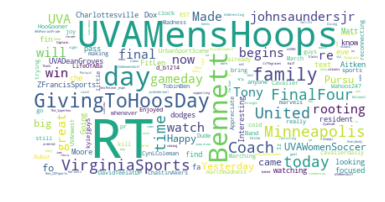

In [31]:
q = sqlContext.sql("SELECT text FROM tweets WHERE user.location = 'Charlottesville, VA'")
text = q.toPandas()
wordcloud = WordCloud(background_color="white").generate(str(text))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [32]:
sentiment = 0
items = list(text['text'])
for item in items:
    analysis = TextBlob(item)
    sentiment += analysis.polarity
avgSent = sentiment / len(items)
city['Charlottesville, VA'] = avgSent
pd.DataFrame.from_dict(city, orient = 'index', columns = ['Avg Polarity'])

,Avg Polarity
"Lubbock, Tx",0.103786
"Charlottesville, VA",0.146215


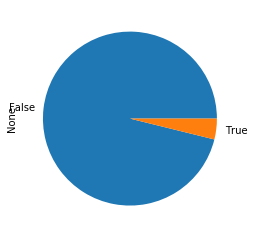

In [33]:
q = sqlContext.sql("SELECT user.verified FROM tweets")
q.toPandas().groupby('verified').size().plot.pie()

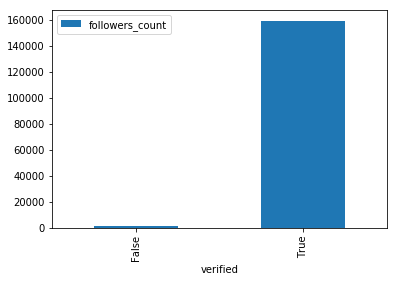

In [35]:
q = sqlContext.sql("SELECT user.verified, user.followers_count FROM tweets")
q.toPandas().groupby('verified').agg('mean').plot.bar()

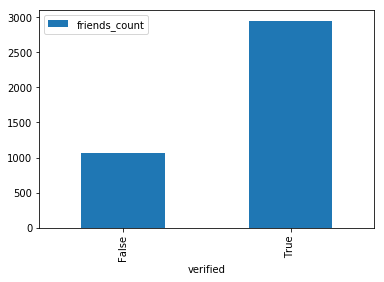

In [36]:
q = sqlContext.sql("SELECT user.verified, user.friends_count FROM tweets")
q.toPandas().groupby('verified').agg('mean').plot.bar()

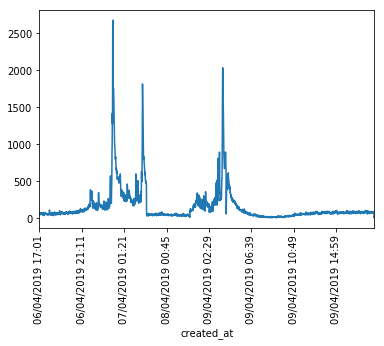

In [38]:
q = sqlContext.sql("SELECT created_at FROM tweets")
df = q.toPandas()
df['created_at'] = pd.to_datetime(df['created_at']).dt.strftime('%d/%m/%Y %H:%M')
counts = df.groupby('created_at').size()
fig = counts.plot(rot=90)